# Analysis of real offline data using the DASK library

In [1]:
import xarray
import tables
import h5py
import numpy
import pandas
import random
import types
from numba import jit
#import blaze
import matplotlib as plt
import matplotlib.pyplot as pyplt
%matplotlib inline
%load_ext Cython

import dask.dataframe
import dask
import dask.multiprocessing

In [2]:
%%cython
import numpy
import math
cimport numpy
DTYPE = numpy.float
ctypedef numpy.float_t DTYPE_t
# from cython.parallel import prange

# Here we define a method to convert an array ordered as (macrobunch, microbunch) into (macrobunch, electron).
# This is needed, for example, to convert bam data into tle electron table.
# THIS IS STILL THE SLOWEST PART!
def assignToMircobunch(numpy.ndarray[DTYPE_t, ndim = 2] microbunchIds, numpy.ndarray[DTYPE_t, ndim = 2] toConvert):
    assert microbunchIds.shape[0] == toConvert.shape[0]
    assert microbunchIds.dtype == DTYPE and toConvert.dtype == DTYPE
    
    cdef int numOfMicrobunches
    cdef int numOfElectrons
    cdef int numOfMacrobunches
    numOfMicrobunches = toConvert.shape[1]
    numOfElectrons = microbunchIds.shape[1]
    numOfMacrobunches = microbunchIds.shape[0]
    
    cdef int macro
    cdef int el
    cdef float microbunchId
    cdef int intMicrobunchId
    cdef numpy.ndarray[DTYPE_t, ndim = 2] result = numpy.zeros([numOfMacrobunches, numOfElectrons], dtype=DTYPE)
    cdef float value
    for macro in range(0, numOfMacrobunches):
        
        for el in range(0, numOfElectrons):
            
            microbunchId = microbunchIds[macro, el]
            if (math.isnan(microbunchId)):
                result[macro, el] =math.nan
                continue
                    
            if (microbunchId < 0):
                result[macro, el] = math.nan
                continue
            
            if (microbunchId >= numOfMicrobunches):
                result[macro, el] = math.nan
                continue
        
            # if everything is OK:
            intMicrobunchId = int(microbunchId)
            result[macro, el] = toConvert[macro, intMicrobunchId]
                
    return result



## Daten, wie sie vom FEL kommen werden
(realer Datensatz, aus HDF5-Datei)

In [3]:
dldTimeStep = 6.0e-3 # ns

In [15]:
# Read the hdf5 file
h5File = h5py.File("dldTestData_offlineTest_13738_all.h5", "r")

# Delay of the delay stage in ps
delaystage = h5File["DLD/delayStage"].value

# DLD data: 4 Vectors per macrobunch
dldPosX = h5File["/DLD/dldPosX"].value
dldPosY = h5File["/DLD/dldPosY"].value
dldTime = h5File["/DLD/dldTime"].value
dldMicrobunchId = h5File["/DLD/dldMicrobunchId"].value

# Beam arrival monitor (BAM) in ps
bam = h5File["/DLD/bam"].value


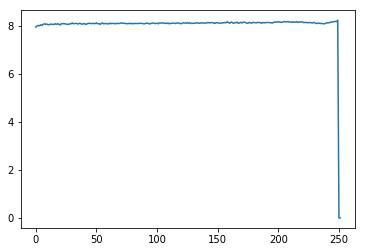

In [16]:
# find the number of microbunches used
pyplt.plot(bam[1,0:252])

## An dieser Stelle würde man nun die Arrays vom DAQ einlesen.

In [17]:
# Create the main array of "clean" electons:
#############################################

numOfMacrobunches = dldPosX.shape[0]

# convert the bam data to electron format
timeArr = assignToMircobunch(dldMicrobunchId, bam)

# and add the delay position to it (not a very nice solution, I know...)
for macro in range(0, numOfMacrobunches):
    timeArr[macro, :] = -timeArr[macro, :]*1e-3 + delaystage[macro]

# scale the dld time to na
dldTime=dldTime*dldTimeStep


chunks = 10000000
# setze den data frame aus einzelnen Arrays zusammen
da1 = dask.array.from_array(dldPosX.flatten(), chunks=(chunks))
del dldPosX # to save RAM
da2 = dask.array.from_array(dldPosY.flatten(), chunks=(chunks))
del dldPosY # to save RAM
da3 = dask.array.from_array(dldTime.flatten(), chunks=(chunks))
del dldTime # to save RAM
da4 = dask.array.from_array(timeArr.flatten(), chunks=(chunks))
del timeArr # to save RAM
da5 = dask.array.from_array(dldMicrobunchId.flatten(), chunks=(chunks))
del dldMicrobunchId # to save RAM
da = dask.array.stack([da1, da2, da3, da4, da5])
# und erzeuge ein dataframe
dd = dask.dataframe.from_array(da.T,
                               columns=('posX','posY', 'dldTime', 'pumpProbeTime', 'dldMicrobunch'))

## The analysis with DASK:

In [18]:
# filter the data:

# get rid of bad microbunches:
numOfMicrobunches = 250 # determined from the plot above
filtered = dd[(dd["dldMicrobunch"] <= numOfMicrobunches) & (dd["dldMicrobunch"] > 0)]

# get rid of points where everything is zero:
fitered = filtered[(filtered['posX'] != 0) & (filtered['posY'] != 0)]

## Simple energy plot (group as dld time)

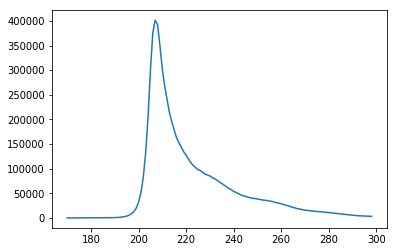

In [19]:
# simple kinetic energy plot:
dldMaxTime = 300 # ns
dldMinTime = 170 # ns
dldTimeRes = 1.0 # ns

# define how to bin in dld time:
binsDldTime = numpy.arange(dldMinTime, dldMaxTime, dldTimeRes)

# do the binning:
binnerDldTime = filtered['dldTime'].map_partitions(pandas.cut, binsDldTime)
# group the data in dld time:
grouped = filtered.groupby([binnerDldTime])
# count the electrons
counted = grouped.count().compute()['posX']
# and plot them
pyplt.plot(binsDldTime[:-1], counted.to_xarray())

## dld time vs. pump-probe time:

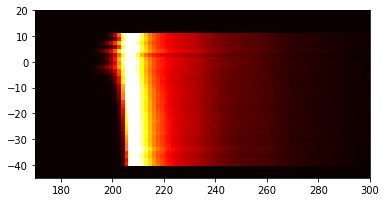

In [20]:
# Define the pump-probe binning:
pumpProbeTimeMin  = -45.0 # ps
pumpProbeTimeMax  =  20.0 # ps
pumpProbeTimeStep =   1.5 # ps
binsPumpProbe = numpy.arange(pumpProbeTimeMin, pumpProbeTimeMax, pumpProbeTimeStep)

# define how to bin in dld time:
dldMaxTime = 300 # ns
dldMinTime = 170 # ns
dldTimeRes = 1.5 # ns
binsDldTime = numpy.arange(dldMinTime, dldMaxTime, dldTimeRes)


# make a histogram of the used delay stage positions (for normalization):
histPumpProbeDelay = numpy.histogram(delaystage[numpy.isfinite(delaystage)], binsPumpProbe)
# pyplt.plot(histPumpProbeDelay[1][:-1], histPumpProbeDelay[0])

# Now we bin the data in 2d:
binnerPumpProbeTime = filtered['pumpProbeTime'].map_partitions(pandas.cut, binsPumpProbe)
binnerDldTime = filtered['dldTime'].map_partitions(pandas.cut, binsDldTime)

grouped = filtered.groupby([binnerPumpProbeTime, binnerDldTime])
# count the electrons
counted = (grouped.count()).compute()['posX']
# now let's normalize it by the pump-probe histogram
arr = counted.to_xarray().values

#print(arr.shape)
arrNormalized = arr/histPumpProbeDelay[0][:,None]

# replace nan by 0:
arrNormalized[numpy.isnan(arrNormalized)]=0
# plot:
pyplt.imshow(arrNormalized, origin='lower', cmap="hot", vmin=0, vmax=3,
             extent=[dldMinTime, dldMaxTime, pumpProbeTimeMin, pumpProbeTimeMax])

## Filter with laser on/off:

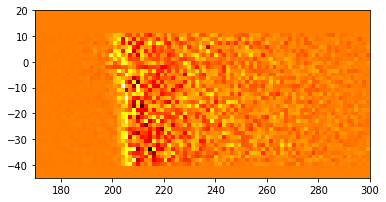

In [21]:
# Leider weiss ich nicht, was die Kriterien für laser on/off sind.... (vermutlich wurde dies
# hier nicht eingesetzt!)
laserOn = filtered[filtered['dldMicrobunch']%2==0]
laserOff = filtered[filtered['dldMicrobunch']%2==1]

# Now we bin the data in 2d:
binnerPumpProbeTimeOn = laserOn['pumpProbeTime'].map_partitions(pandas.cut, binsPumpProbe)
binnerPumpProbeTimeOff = laserOff['pumpProbeTime'].map_partitions(pandas.cut, binsPumpProbe)
binnerDldTimeOn = laserOn['dldTime'].map_partitions(pandas.cut, binsDldTime)
binnerDldTimeOff = laserOff['dldTime'].map_partitions(pandas.cut, binsDldTime)


groupedOn = laserOn.groupby([binnerPumpProbeTimeOn, binnerDldTimeOn])
groupedOff = laserOff.groupby([binnerPumpProbeTimeOff, binnerDldTimeOff])

countedOn = (groupedOn.count()).compute()['posX'].to_xarray().values
countedOff = (groupedOff.count())['posX'].compute().to_xarray().values

normOn = laserOn['posX'].count()
normOff = laserOff['posX'].count()
arr = (countedOn/normOn-countedOff/normOff)

histPumpProbeDelay = numpy.histogram(delaystage[numpy.isfinite(delaystage)], binsPumpProbe)
arrNormalized = arr/histPumpProbeDelay[0][:,None]
arrNormalized[numpy.isnan(arrNormalized)] = 0.0
# plot:
pyplt.imshow(arrNormalized, origin='lower', cmap="hot",
             extent=[dldMinTime, dldMaxTime, pumpProbeTimeMin, pumpProbeTimeMax])

In [11]:
# Here, we do the binning:
binsDldTime = range(0, 10000, 500)
binsXY = range(0, 1000, 5)
grouperX = filtered['posX'].map_partitions(pandas.cut, binsXY)
grouperY = filtered['posY'].map_partitions(pandas.cut, binsXY)

binnerDldTime = dd['pumpProbeTime'].map_partitions(pandas.cut, binsDldTime)
grouped = filtered.groupby([binnerDldTime, grouperX, grouperY])

In [12]:
# The actual event counting happens here (using parallel processing!):
counted = (grouped['bam'].count()).compute()

KeyError: 'Column not found: bam'

In [ ]:
# The xarray DataArray can easily be unstacked:
countedArr = (xarray.DataArray(counted)).unstack('dim_0')